# Housing Sale Prediction

In [600]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression, chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

# Variables

In [601]:
SUBMISSION_VERSION = "v2"
MAX_CARDINALITY = 11
Y_COLUMN = 'SalePrice'
NUMERICAL_COLS = ['LotFrontage', 'LotArea', 'Fireplaces', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                         'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'TotalBsmtSF', 'BsmtUnfSF',
                         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
ORDINAL_COLS = ['LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC', 'Fence']

## 1. Data Import and Basic Preprocessing

### 1.1 Data Loading and Check for NAN

In [602]:
train_df = pd.read_csv('../data/housing/train.csv', keep_default_na=False, index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [603]:
train_df.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

In [604]:
train_df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [605]:
test_df = pd.read_csv('../data/housing/test.csv', keep_default_na=False, index_col='Id')
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


In [606]:
len(test_df)

1459

In [607]:
test_df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

In [608]:
test_df.dtypes

MSSubClass        int64
MSZoning         object
LotFrontage      object
LotArea           int64
Street           object
                  ...  
MiscVal           int64
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
Length: 79, dtype: object

### 1.3 Replacing numerical_cols NA Values with 0

Looks like this is being caused by the fact there are some entries which have NA, which I assume apply to houses that don't meet the criteria ie. if you don't have a Masonry Veneer then this is being recorded as NA. I am going to preprocess this so all numerical dtypes which have NA entries replace these with 0, as having zero area is the same thing has not having that feature in your property.

In [609]:
train_df_incorrect_numerical_types = [cname for cname in NUMERICAL_COLS if train_df[cname].dtype == object]
train_df_incorrect_numerical_types

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [610]:
train_df[train_df_incorrect_numerical_types] = train_df[train_df_incorrect_numerical_types].replace({'NA': 0}).astype(int)
train_df[NUMERICAL_COLS].dtypes

LotFrontage      int64
LotArea          int64
Fireplaces       int64
YearBuilt        int64
YearRemodAdd     int64
MasVnrArea       int64
BsmtFinSF1       int64
BsmtFinSF2       int64
1stFlrSF         int64
2ndFlrSF         int64
LowQualFinSF     int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
Fireplaces       int64
GarageYrBlt      int64
GarageCars       int64
GarageArea       int64
WoodDeckSF       int64
TotalBsmtSF      int64
BsmtUnfSF        int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
PoolArea         int64
MiscVal          int64
MoSold           int64
YrSold           int64
dtype: object

In [611]:
test_df_incorrect_numerical_types = [cname for cname in NUMERICAL_COLS if test_df[cname].dtype == object]
test_df_incorrect_numerical_types

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 'BsmtUnfSF']

In [612]:
test_df[test_df_incorrect_numerical_types] = test_df[test_df_incorrect_numerical_types].replace({'NA': 0}).astype(int)
test_df[test_df_incorrect_numerical_types].dtypes

LotFrontage     int64
MasVnrArea      int64
BsmtFinSF1      int64
BsmtFinSF2      int64
BsmtFullBath    int64
BsmtHalfBath    int64
GarageYrBlt     int64
GarageCars      int64
GarageArea      int64
TotalBsmtSF     int64
BsmtUnfSF       int64
dtype: object

### 1.4 Replacing Ordinal String Values

ExterQuality, ExterCond and LandSlope all have strings representing their ordinal values.

In [613]:
numerical_ordinal_cols = ['OverallQual', 'OverallCond']
string_ordinal_cols = [cname for cname in ORDINAL_COLS if cname not in numerical_ordinal_cols]

In [614]:
string_ordinal_categories = [['Sev', 'Mod', 'Gtl'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['NA', 'No', 'Mn', 'Av', 'Gd'],
                             ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                             ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['NA', 'Unf', 'RFn', 'Fin'],
                             ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                             ['NA', 'Fa', 'Gd', 'Ex'],
                             ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

In [616]:
string_converted_ordinal_categories = [[i for i in range(0, len(cat))] for cat in string_ordinal_categories]

[[0, 1, 2],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4]]

In [632]:
ordinal_conversion_map = {cname: {s: string_converted_ordinal_categories[i][j]}
                          for cname in string_ordinal_cols
                          for i, vals in enumerate(string_ordinal_categories)
                          for j, s in enumerate(vals)}
ordinal_conversion_map

{'Sev': 0,
 'Mod': 1,
 'Gtl': 2,
 'Po': 1,
 'Fa': 1,
 'TA': 3,
 'Gd': 2,
 'Ex': 3,
 'NA': 0,
 'No': 1,
 'Mn': 2,
 'Av': 3,
 'Unf': 1,
 'LwQ': 2,
 'Rec': 3,
 'BLQ': 4,
 'ALQ': 5,
 'GLQ': 6,
 'RFn': 2,
 'Fin': 3,
 'MnWw': 1,
 'GdWo': 2,
 'MnPrv': 3,
 'GdPrv': 4}

In [625]:
test = dict(zip(string_ordinal_categories, string_converted_ordinal_categories))
test

TypeError: unhashable type: 'list'

In [623]:
string_to_numerical_ordinal_dict = dict(zip(string_ordinal_cols, ))
string_to_numerical_ordinal_dict


TypeError: unhashable type: 'list'

In [621]:
train_df.replace(string_to_numerical_ordinal_dict, inplace=True)
train_df[ORDINAL_COLS]

,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
Id,,,,,,,,,,,,,,,,,,
1,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,NA,RFn,TA,TA,NA,NA
2,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,TA,TA,RFn,TA,TA,NA,NA
3,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,NA,NA
4,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Gd,Gd,Unf,TA,TA,NA,NA
5,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Gtl,6,5,TA,TA,Gd,TA,No,Unf,Unf,Ex,TA,TA,RFn,TA,TA,NA,NA
1457,Gtl,6,6,TA,TA,Gd,TA,No,ALQ,Rec,TA,TA,TA,Unf,TA,TA,NA,MnPrv
1458,Gtl,7,9,Ex,Gd,TA,Gd,No,GLQ,Unf,Ex,Gd,Gd,RFn,TA,TA,NA,GdPrv


## 2. EDA

### 2.1 SalesPrice Analysis

In [538]:
sale_price = train_df[Y_COLUMN]
sale_price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

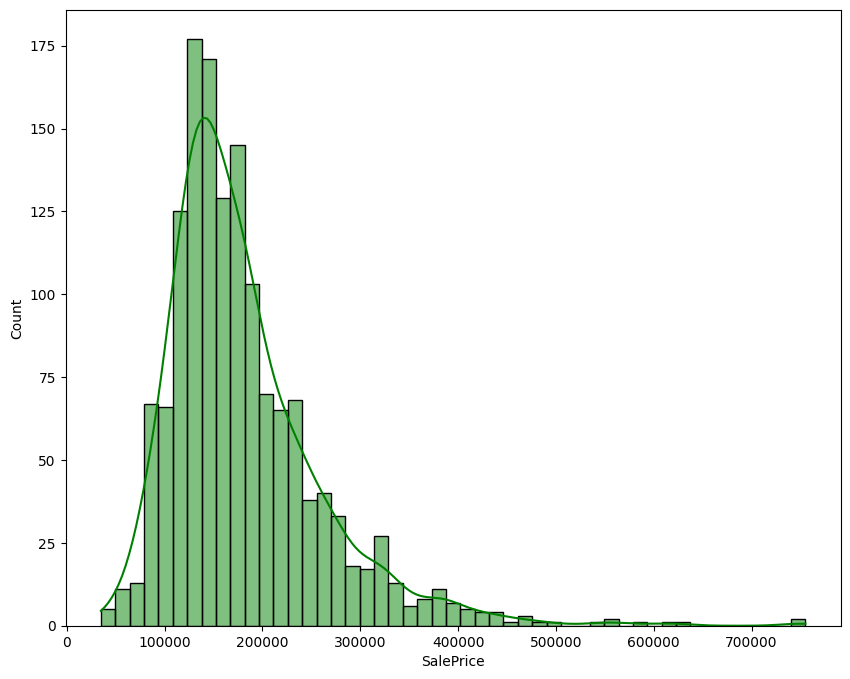

In [539]:
plt.figure(figsize=(10, 8))
sns.histplot(sale_price, color='g', kde=True)

The above histogram indicates a positive skew with the majority of observation values below the mean house price.

### 2.2 Numerical Feature Analysis

In [540]:
train_numerical_df = train_df[actual_numerical_cols]
train_numerical_df.head()

,LotFrontage,LotArea,Fireplaces,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,1stFlrSF,2ndFlrSF,...,TotalBsmtSF,BsmtUnfSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,65,8450,0,2003,2003,196,706,0,856,854,...,856,150,61,0,0,0,0,0,2,2008
2,80,9600,1,1976,1976,0,978,0,1262,0,...,1262,284,0,0,0,0,0,0,5,2007
3,68,11250,1,2001,2002,162,486,0,920,866,...,920,434,42,0,0,0,0,0,9,2008
4,60,9550,1,1915,1970,0,216,0,961,756,...,756,540,35,272,0,0,0,0,2,2006
5,84,14260,1,2000,2000,350,655,0,1145,1053,...,1145,490,84,0,0,0,0,0,12,2008


In [541]:
train_numerical_df.describe()

,LotFrontage,LotArea,Fireplaces,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,1stFlrSF,2ndFlrSF,...,TotalBsmtSF,BsmtUnfSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,57.623288,10516.828082,0.613014,1971.267808,1984.865753,103.117123,443.639726,46.549315,1162.626712,346.992466,...,1057.429452,567.240411,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,34.664304,9981.264932,0.644666,30.202904,20.645407,180.731373,456.098091,161.319273,386.587738,436.528436,...,438.705324,441.866955,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,0.000000,1300.000000,0.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,42.000000,7553.500000,0.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,882.000000,0.000000,...,795.750000,223.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,63.000000,9478.500000,1.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,1087.000000,0.000000,...,991.500000,477.500000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,79.000000,11601.500000,1.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,1391.250000,728.000000,...,1298.250000,808.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,3.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,4692.000000,2065.000000,...,6110.000000,2336.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'GarageYrBlt'}>],
       [<Axes: title={'center': 'GarageCars'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDec

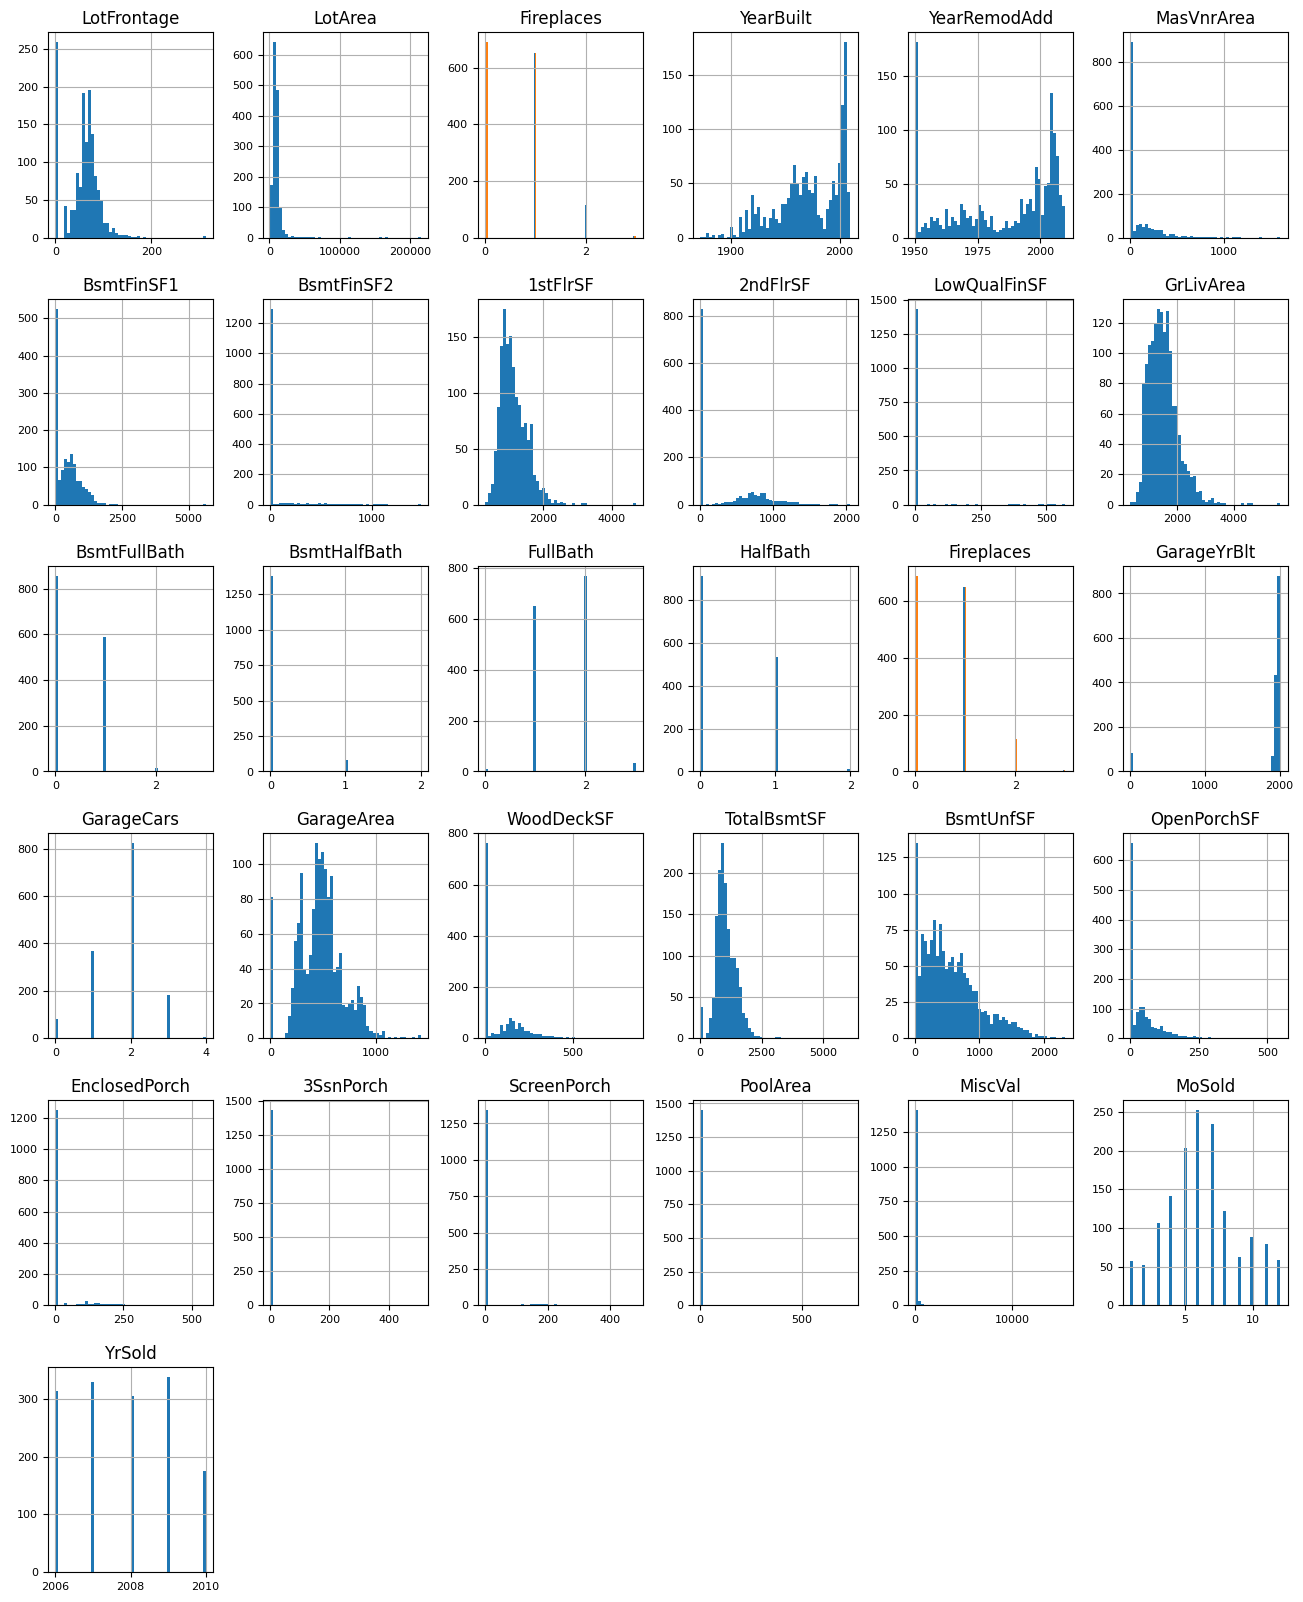

In [542]:
train_numerical_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [543]:
test_numerical_df = test_df[NUMERICAL_COLS]
test_numerical_df.describe()

,LotFrontage,LotArea,Fireplaces,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,1stFlrSF,2ndFlrSF,...,TotalBsmtSF,BsmtUnfSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.910212,9819.161069,0.58122,1971.357779,1983.662783,99.673749,438.902673,52.583276,1156.534613,325.967786,...,1045.400960,553.915010,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,32.266054,4955.517327,0.64742,30.390071,21.130467,177.001792,455.257119,176.698671,398.165820,420.610226,...,443.592976,437.351324,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,0.000000,1470.000000,0.00000,1879.000000,1950.000000,0.000000,0.000000,0.000000,407.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,44.000000,7391.000000,0.00000,1953.000000,1963.000000,0.000000,0.000000,0.000000,873.500000,0.000000,...,784.000000,219.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,63.000000,9399.000000,0.00000,1973.000000,1992.000000,0.000000,350.000000,0.000000,1079.000000,0.000000,...,988.000000,460.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,78.000000,11517.500000,1.00000,2001.000000,2004.000000,162.000000,752.000000,0.000000,1382.500000,676.000000,...,1304.000000,797.500000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,200.000000,56600.000000,4.00000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,5095.000000,1862.000000,...,5095.000000,2140.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'GarageYrBlt'}>],
       [<Axes: title={'center': 'GarageCars'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDec

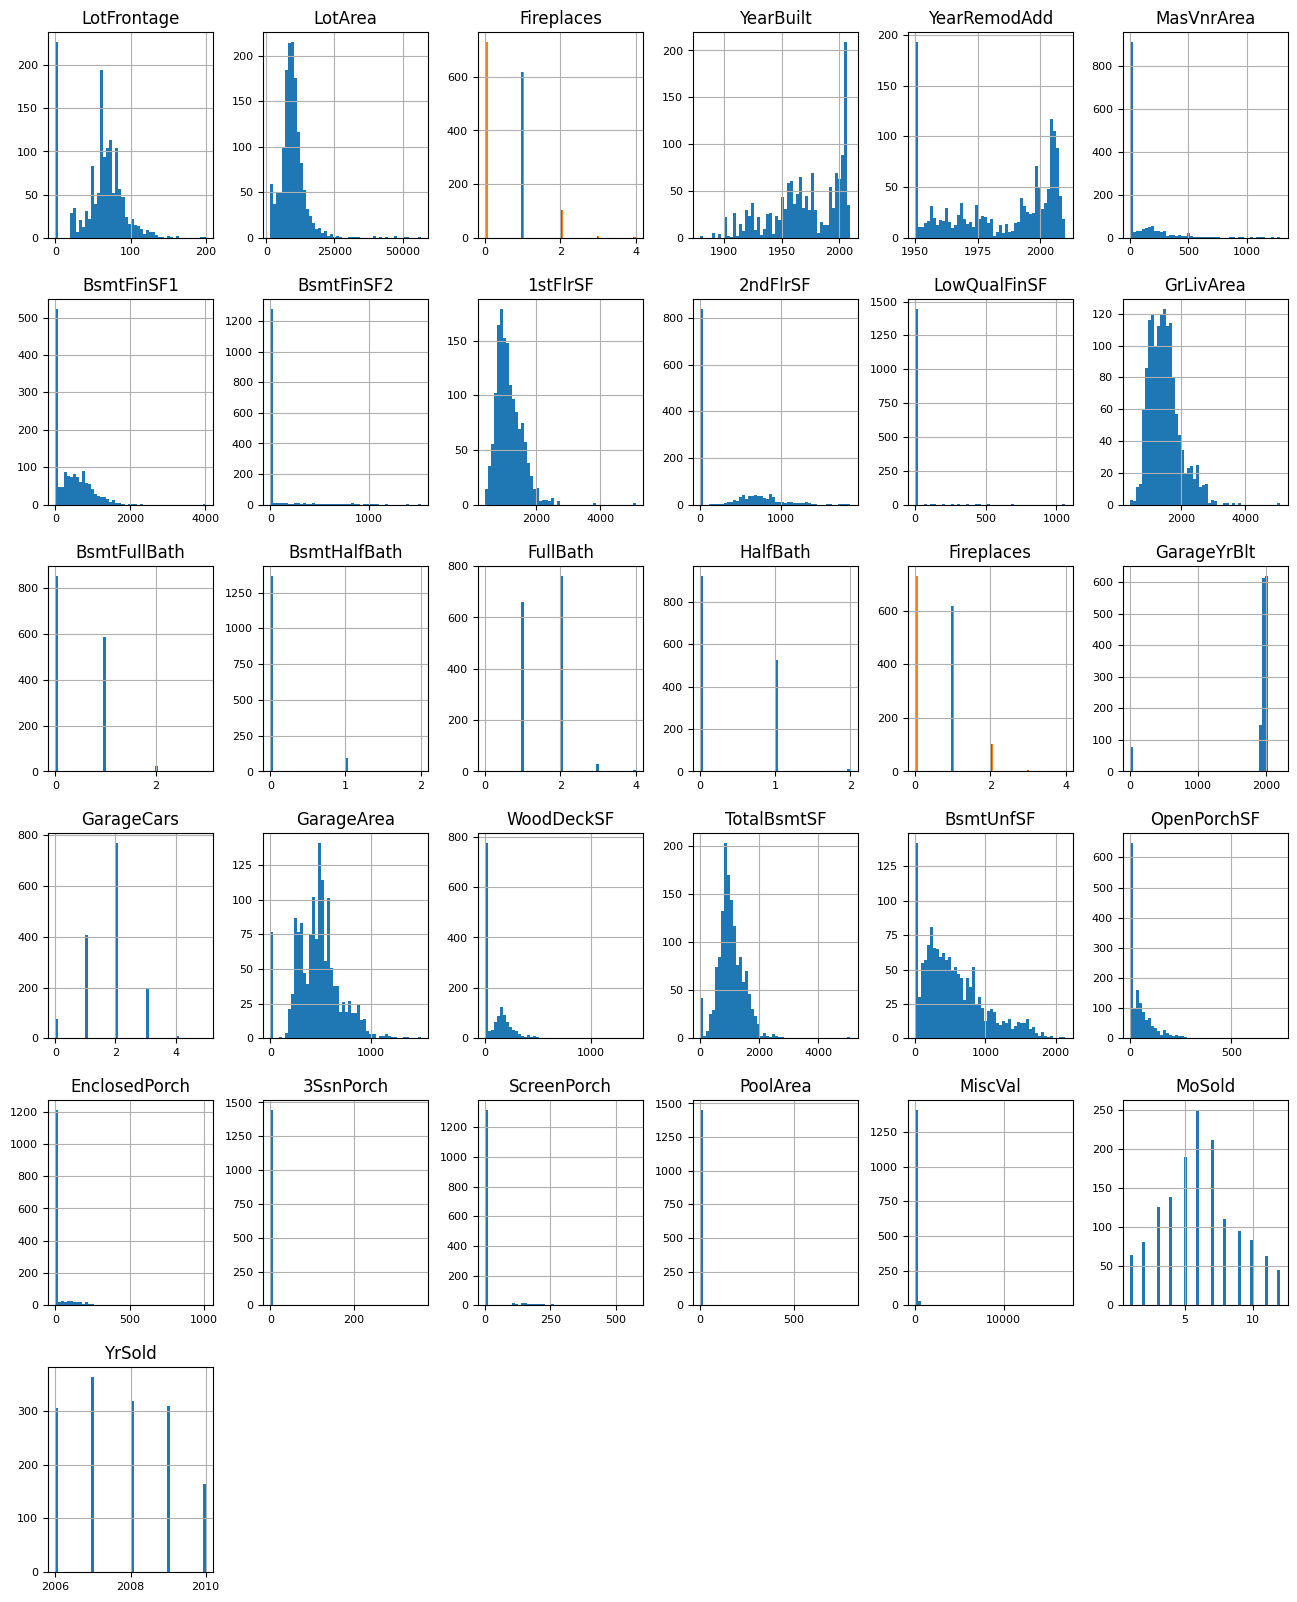

In [544]:
test_numerical_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### 2.3 EDA Summary

There are some interesting observations after reviewing the hist plot for the numerical data points:

* 1. Positive skews: there are quite a few categories which have high positive skew being caused by significant 0 data points (Pool Area etc.). Leaves some rationale for converting these columns to binary or ordinal encoding (quartiles).
* 2. Normalization: SalesPrice and other entries could potentially be normalized to help improve regression results.

## 3. Data Preprocessing

In [545]:
def create_categorical_cols(train: pd.DataFrame,
                            test: pd.DataFrame,
                            cols_to_ignore: list[str]) -> list[str]:
    """_summary_

    Args:
        df (pd.Dataframe): _description_
        cols_to_ignore (list[str]): _description_

    Returns:
        list[str]: _description_
    """
    return [cname for cname in train.columns
            if cname not in cols_to_ignore and
            train[cname].nunique() < MAX_CARDINALITY and
            train[cname].dtype == "object" and
            test[cname].nunique() < MAX_CARDINALITY and
            test[cname].dtype == "object"]

def create_numerical_cols(train: pd.DataFrame,
                          test: pd.DataFrame,
                          cols_to_ignore: list[str]) -> list[str]:
    """_summary_

    Args:
        train (pd.DataFrame): _description_
        test (pd.DataFrame): _description_
    
    Returns:
        list[str]: _description_
    """
    return [cname for cname in train.columns
            if cname not in cols_to_ignore and
            train[cname].dtype in ['int64', 'float64'] and
            test[cname].dtype in ['int64', 'float64']]

Created a combined_df so that the full ordinal and categorical categories can be passed to the Encoders.

In [546]:
combined_df = pd.concat([train_df.drop('SalePrice', axis=1), test_df])

### 3.1 Ordinal Encoding

There appears to be quite alot of ordinal data which isn't being encoded properly. I will not add a preprocessor stage for these columns in an attempt to improve model accuracy. 

There are some columns which have Ordinal Rankings which are dependant on other factors, such as BsmtQual, which ranks Po to Ex if there is a basement, or NA if a basement doesn't exist. I intend to include these in ordinal_columns for this regression and will review the results.

I am also going to have to 

In [547]:
y_column = 'SalePrice'
X_train, X_valid, y_train, y_valid = y_and_train_test_split(train_df, y_column, 0.8)

In [598]:
ordinal_categories = [combined_df[cname].unique() for cname in ORDINAL_COLS]
ordinal_categories

[array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2]),
 array([5, 8, 6, 7, 4, 2, 3, 9, 1]),
 array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object),
 array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object),
 array(['Gd', 'TA', 'Ex', 'NA', 'Fa'], dtype=object),
 array(['TA', 'Gd', 'NA', 'Fa', 'Po'], dtype=object),
 array(['No', 'Gd', 'Mn', 'Av', 'NA'], dtype=object),
 array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ'], dtype=object),
 array(['Unf', 'BLQ', 'NA', 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object),
 array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object),
 array(['Gd', 'TA', 'Ex', 'Fa', 'NA'], dtype=object),
 array(['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object),
 array(['RFn', 'Unf', 'Fin', 'NA'], dtype=object),
 array(['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po'], dtype=object),
 array(['TA', 'Fa', 'NA', 'Gd', 'Po', 'Ex'], dtype=object),
 array(['NA', 'Ex', 'Fa', 'Gd'], dtype=object),
 array(['NA', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)]

In [565]:
ordinal_transformer = Pipeline(
    steps=[
        ('ordinal', OrdinalEncoder(categories=ordinal_categories))
    ]
)

### 3.2 Create Categorical Transformer

In [566]:
categorical_cols = create_categorical_cols(X_train, test_df, ORDINAL_COLS)

In [567]:
categorical_col_categories = [combined_df[cname].unique() for cname in categorical_cols]

In [568]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(categories=categorical_col_categories))        
    ]
)

### 3.3 Create Numerical Transformer

In [569]:
numerical_transformer = SimpleImputer(strategy='constant')

In [570]:
numerical_cols = create_numerical_cols(X_train, test_df, ORDINAL_COLS)

### 3.4 Update X_train

?? Necessary

In [571]:
full_cols = ordinal_cols + categorical_cols + numerical_cols
X_train = X_train[full_cols].copy()
X_valid = X_valid[full_cols].copy()
X_test = test_df[full_cols].copy()

## 4. Model Definition and Training

### 4.1 New Preprocessor and Model Definition

In [572]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ]
)

In [573]:
pipeline = Pipeline(
    steps=[
        ('column_transformer', column_transformer),
        ('variance_threshold', VarianceThreshold(threshold=0.0)),
        ('select_percentile', SelectPercentile(chi2, percentile=95)),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=0))
    ]
)

### 4.2 Hyperparameter Tuning

In [574]:
param_grid = {
    'model__n_estimators': [50, 60, 70, 80, 90, 100, 125, 150]
}

grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid,
                           n_jobs=2)

In [575]:
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

### 4.2 Training and Evaluation

In [576]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'Bedroo...
                                                                                               3,
                                                                                               4,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9,
                                                                                               10],
                                                                                              [1,
                                                                                               2,
                                                                                               3,
                                                                                               4,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9],
                                                                                              ['Ex',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'TA'],
                                                                                              ['Ex',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'Po',
                                                                                               'TA']]))]),
                                                  ['LandSlope', 'OverallQual',
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond'])])),
                ('variance_threshold', VarianceThreshold()),
                ('select_percentile',
                 SelectPercentile(percentile=95,
                                  score_func=<function chi2 at 0x7f6549a73520>)),
       

In [577]:
pred = pipeline.predict(X_valid)

In [578]:
mea = mean_absolute_error(y_valid, pred)
mea

17567.249897260273

In [579]:
rmse = root_mean_squared_error(y_valid, pred)
rmse

34186.1346521277

In [580]:
preds_test = pipeline.predict(X_test)

In [581]:
output_preds(X_test, preds_test, 'v2')

## 5 Model Evaluation

### 5.1 Check for missing columns

In [582]:
missing_cols = [cname for cname in test_df.columns if cname not in full_cols]
missing_cols

['Neighborhood', 'Exterior1st', 'Exterior2nd']

### 5.3 Feature Importances

In [583]:
model = pipeline['model']
column_transformer = pipeline['column_transformer']
select_percentile = pipeline['select_percentile']

In [584]:
feature_importances = model.feature_importances_
original_feature_names = column_transformer.get_feature_names_out()
feature_names = [original_feature_names[i] for i, _name in enumerate(select_percentile.get_feature_names_out())]

In [585]:
print(f"feature_importances: {len(feature_importances)}, feature_names: {len(feature_names)}")

feature_importances: 222, feature_names: 222


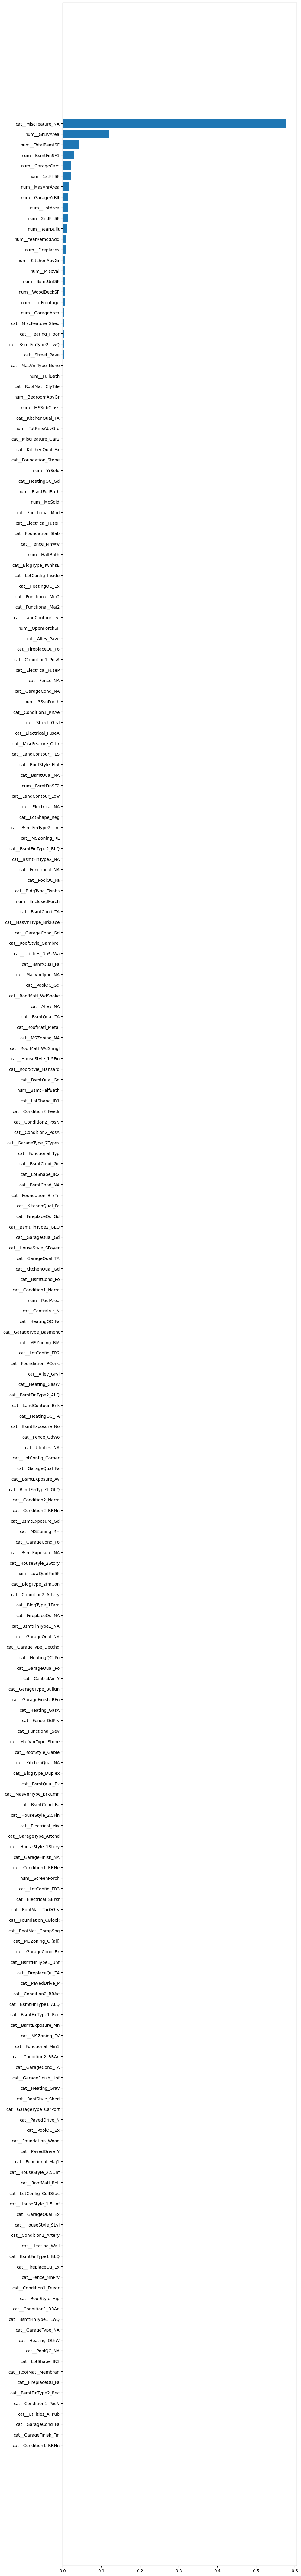

In [586]:
f_i = list(zip(feature_names, feature_importances))
f_i.sort(key=lambda x: x[1])
plt.figure(figsize=[10, 110])
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.show()

### Evaluation Points

* 1. Improved Feature Selection: there are over 200 features currently which is far too complicated. Need to reduce.
* 2. Replacing some Ordinal Encoding with Binary Encoding: there are certain values which are currently being treated as Ordinal values which could be replaced by Binary Encoding (MiscFeature, Fence).
* 3. Improving One Hot Encoding: there are some features which are in test data and not in training data etc so the OneHotEncoders need to be passed all values.
* 3. Model Selection: use GradientBoostedTrees or another model instead of RandomForrest.